## Using pre-trained models for Texture Classification
In this lab, we will use pre-trained models for the same texture classification task. The dataset we will be using is available here: http://dx.doi.org/10.5281/zenodo.53169. 

![alt text](https://www.researchgate.net/profile/Jakob_Kather/publication/303998214/figure/fig7/AS:391073710002224@1470250646407/Representative-images-from-our-dataset-Here-the-first-10-images-of-every-tissue-class.png)

The above figure shows the 8 different classes of tissue we will be trying to identify. 

In [0]:
from __future__ import print_function
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from matplotlib import pylab as plt
from skimage.color import rgb2lab, rgb2hsv

## Step 1: Load pre-trained VGG16 model
We will use the VGG16 model as the feature extractor for this classification task. First, we need to download the pre-trained weights. The model has been trained on the ImageNet image classification dataset. For more details on this dataset see http://www.image-net.org/. 

In [2]:
model = None
model = VGG16(weights='imagenet', include_top=False, input_shape = (150, 150, 3))
#model.summary()

58900480/58889256 [==============================] - 1s 0us/step


## VGG16
Let's examine the VGG16 model. The model has 16 layers as seen above. The model has the following specifications
* Expected input size : 224x224 pixels
* Number of output classes : 1000

Our images are 150x150 pixels in size and come from only 10 categories. In order to use this model for our classification task, we need to do the following:
* Resize images : Our input images can be resized to the appropriate dimensions. Alternatively, we can pad our images to the expected dimensions. Padding leads to additional choices - Do we pad with zeros, duplicate edge pixels or mirror the image across edges ?
* Change the prediction layer : Remove the existing prediction layer and add a new layer that can predict 8 classes.
* Train : Finally, we need to train the network on our data

# Step 2
Load the data and resize images appropriately. Use the helper function in utils.py. The assumption is that you have already cloned the Week3 repo and know the path to the data folder.

In [0]:
def load_crc_data(data_dir):
    y = np.load(os.path.join(data_dir, 'rgb01.npz'))
    labels = y['labels']
    data = y['rgb_data']
    label_str = y['label_str']
    label_str = label_str.tolist() # this is to convert label_str back to a dictionary
    y = []

    for ii in range(2,6):
        filename = os.path.join(data_dir, 'rgb0' + str(ii) + '.npz')
        print('loading ', filename)
        y = np.load(filename)
        labels = np.append(labels, y['labels'], axis=0)
        data = np.append(data, y['rgb_data'], axis=0)
        print(data.shape)

    return data, labels, label_str

In [5]:
#! git clone https://github.com/BeaverWorksMedlytics/Week3_public.git
os.chdir('..')
from skimage.transform import resize
from sklearn.model_selection import train_test_split
data_dir = os.path.join( os.getcwd(), 'Week3_public', 'data', 'crc')
data, labels, label_str = load_crc_data(data_dir)
num_images = data.shape[0]

Cloning into 'Week3_public'...
remote: Counting objects: 82, done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82
Unpacking objects: 100% (82/82), done.
Checking out files: 100% (25/25), done.
loading  /Week3_public/data/crc/rgb02.npz
(2000, 150, 150, 3)
loading  /Week3_public/data/crc/rgb03.npz
(3000, 150, 150, 3)
loading  /Week3_public/data/crc/rgb04.npz
(4000, 150, 150, 3)
loading  /Week3_public/data/crc/rgb05.npz
(5000, 150, 150, 3)


In [0]:
# Resize data
#resized_data = np.zeros((num_images, 224, 224, 3))
#for ii in range(0, num_images):
#    resized_data[ii,::] = resize(data[ii,::], (224, 224, 3), mode='symmetric')
#data = resized_data
#resized_data = []
#print(data.shape)

(5000, 224, 224, 3)


In [0]:
#with open('resized.npz', 'wb') as fp:
#    np.savez(fp, data=data, labels=labels)

In [0]:
# Split data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=.2)
data = None
ntrain = train_images.shape[0]
ntest  = test_images.shape[0]

## Step 3
We will now modify the pre-trained VGG network as described earlier. We will remove the following layers : 

<img src="images/final_layers.png" width="65%"></img> 


In [7]:
# remove the final layer in the model
for ii in range(0,4):
    model.layers.pop()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [8]:
# Convert into sequential
seq_model = None
seq_model = Sequential()
for layer in model.layers:
    seq_model.add( layer )
seq_model.summary()

for ii in range(0,1):
    seq_model.pop()

seq_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
__________

# Step 4
Freeze the layers that remain in our model.

In [9]:
for layer in seq_model.layers:
    layer.trainable = False
seq_model.summary()

seq_model.add( Flatten(name="my_flatten") )
#seq_model.add( Dense(1024, activation="relu", name="new_dense1") )
#seq_model.add( Dropout(0.5) )
#seq_model.add( Dense(64, activation="relu", name="new_dense2") )
seq_model.add( Dense(8, activation="relu", name="predictions") )

seq_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
__________

In [0]:
seq_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics = ['accuracy'])

In [0]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [15]:
y = seq_model.fit(train_images, train_labels, validation_data=(test_images, test_labels),
                  batch_size=64, epochs=100, verbose=1)

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.5568 - acc: 0.2527 - val_loss: 1.5295 - val_acc: 0.2750
Epoch 2/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.5438 - acc: 0.2555 - val_loss: 1.5163 - val_acc: 0.2750
Epoch 3/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.5317 - acc: 0.2595 - val_loss: 1.5041 - val_acc: 0.2780
Epoch 4/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.5205 - acc: 0.2625 - val_loss: 1.4930 - val_acc: 0.2800
Epoch 5/100
1024/4000 [======>.......................] - ETA: 13s - loss: 1.5287 - acc: 0.2559

4000/4000 [==============================] - 22s 6ms/step - loss: 1.5100 - acc: 0.2665 - val_loss: 1.4824 - val_acc: 0.2850
Epoch 6/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.4997 - acc: 0.2690 - val_loss: 1.4721 - val_acc: 0.2870
Epoch 7/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.4897 - acc: 0.2722 - val_loss: 1.4620 - val_acc: 0.2880
Epoch 8/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.4799 - acc: 0.2755 - val_loss: 1.4521 - val_acc: 0.2920
Epoch 9/100
2816/4000 [====================>.........] - ETA: 5s - loss: 1.4842 - acc: 0.2731

4000/4000 [==============================] - 22s 6ms/step - loss: 1.4702 - acc: 0.2790 - val_loss: 1.4422 - val_acc: 0.2950
Epoch 10/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.4605 - acc: 0.2812 - val_loss: 1.4322 - val_acc: 0.2970
Epoch 11/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.4507 - acc: 0.2830 - val_loss: 1.4223 - val_acc: 0.3020
Epoch 12/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.4409 - acc: 0.2865 - val_loss: 1.4123 - val_acc: 0.3050
Epoch 13/100
3008/4000 [=====================>........] - ETA: 4s - loss: 1.4396 - acc: 0.2852

4000/4000 [==============================] - 22s 6ms/step - loss: 1.4310 - acc: 0.2910 - val_loss: 1.4021 - val_acc: 0.3080
Epoch 14/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.4209 - acc: 0.2948 - val_loss: 1.3917 - val_acc: 0.3120
Epoch 15/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.4107 - acc: 0.2975 - val_loss: 1.3812 - val_acc: 0.3160
Epoch 16/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.4003 - acc: 0.2993 - val_loss: 1.3704 - val_acc: 0.3180
Epoch 17/100
3008/4000 [=====================>........] - ETA: 4s - loss: 1.3820 - acc: 0.3052

4000/4000 [==============================] - 22s 6ms/step - loss: 1.3898 - acc: 0.3008 - val_loss: 1.3595 - val_acc: 0.3230
Epoch 18/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.3791 - acc: 0.3045 - val_loss: 1.3483 - val_acc: 0.3250
Epoch 19/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.3683 - acc: 0.3070 - val_loss: 1.3370 - val_acc: 0.3330
Epoch 20/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.3574 - acc: 0.3122 - val_loss: 1.3255 - val_acc: 0.3390
Epoch 21/100
3008/4000 [=====================>........] - ETA: 4s - loss: 1.3431 - acc: 0.3201

4000/4000 [==============================] - 22s 6ms/step - loss: 1.3463 - acc: 0.3152 - val_loss: 1.3141 - val_acc: 0.3440
Epoch 22/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.3353 - acc: 0.3180 - val_loss: 1.3029 - val_acc: 0.3480
Epoch 23/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.3245 - acc: 0.3212 - val_loss: 1.2918 - val_acc: 0.3530
Epoch 24/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.3135 - acc: 0.3265 - val_loss: 1.2808 - val_acc: 0.3560
Epoch 25/100
3008/4000 [=====================>........] - ETA: 4s - loss: 1.3030 - acc: 0.3285

4000/4000 [==============================] - 22s 6ms/step - loss: 1.3026 - acc: 0.3297 - val_loss: 1.2698 - val_acc: 0.3600
Epoch 26/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.2919 - acc: 0.3335 - val_loss: 1.2589 - val_acc: 0.3630
Epoch 27/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.2810 - acc: 0.3372 - val_loss: 1.2488 - val_acc: 0.3690
Epoch 28/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.2702 - acc: 0.3420 - val_loss: 1.2368 - val_acc: 0.3720
Epoch 29/100
3008/4000 [=====================>........] - ETA: 4s - loss: 1.2569 - acc: 0.3481

4000/4000 [==============================] - 22s 6ms/step - loss: 1.2593 - acc: 0.3455 - val_loss: 1.2261 - val_acc: 0.3780
Epoch 30/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.2486 - acc: 0.3503 - val_loss: 1.2170 - val_acc: 0.3850
Epoch 31/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.2378 - acc: 0.3528 - val_loss: 1.2050 - val_acc: 0.3870
Epoch 32/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.2271 - acc: 0.3570 - val_loss: 1.1941 - val_acc: 0.3920
Epoch 33/100
3008/4000 [=====================>........] - ETA: 4s - loss: 1.2120 - acc: 0.3594

4000/4000 [==============================] - 22s 6ms/step - loss: 1.2161 - acc: 0.3590 - val_loss: 1.1935 - val_acc: 0.3960
Epoch 34/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.2051 - acc: 0.3627 - val_loss: 1.1824 - val_acc: 0.4030
Epoch 35/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.1945 - acc: 0.3678 - val_loss: 1.1716 - val_acc: 0.4060
Epoch 36/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.1836 - acc: 0.3745 - val_loss: 1.1609 - val_acc: 0.4140
Epoch 37/100
3008/4000 [=====================>........] - ETA: 4s - loss: 1.1764 - acc: 0.3757

4000/4000 [==============================] - 22s 6ms/step - loss: 1.1726 - acc: 0.3790 - val_loss: 1.1502 - val_acc: 0.4190
Epoch 38/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.1616 - acc: 0.3840 - val_loss: 1.1397 - val_acc: 0.4230
Epoch 39/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.1504 - acc: 0.3882 - val_loss: 1.1285 - val_acc: 0.4320
Epoch 40/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.1389 - acc: 0.3947 - val_loss: 1.1180 - val_acc: 0.4380
Epoch 41/100
3008/4000 [=====================>........] - ETA: 4s - loss: 1.1296 - acc: 0.3939

4000/4000 [==============================] - 22s 6ms/step - loss: 1.1272 - acc: 0.3995 - val_loss: 1.1063 - val_acc: 0.4440
Epoch 42/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.1150 - acc: 0.4080 - val_loss: 1.0940 - val_acc: 0.4540
Epoch 43/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.1026 - acc: 0.4160 - val_loss: 1.0827 - val_acc: 0.4660
Epoch 44/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.0896 - acc: 0.4263 - val_loss: 1.0694 - val_acc: 0.4740
Epoch 45/100
3008/4000 [=====================>........] - ETA: 4s - loss: 1.0710 - acc: 0.4378

4000/4000 [==============================] - 22s 6ms/step - loss: 1.0757 - acc: 0.4333 - val_loss: 1.0576 - val_acc: 0.4840
Epoch 46/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.0615 - acc: 0.4440 - val_loss: 1.0433 - val_acc: 0.4910
Epoch 47/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.0459 - acc: 0.4537 - val_loss: 1.0290 - val_acc: 0.4960
Epoch 48/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.0295 - acc: 0.4642 - val_loss: 1.0261 - val_acc: 0.5010
Epoch 49/100
3008/4000 [=====================>........] - ETA: 4s - loss: 1.0049 - acc: 0.4751

4000/4000 [==============================] - 22s 6ms/step - loss: 1.0115 - acc: 0.4753 - val_loss: 1.0094 - val_acc: 0.5080
Epoch 50/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.9916 - acc: 0.4898 - val_loss: 0.9903 - val_acc: 0.5180
Epoch 51/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.9700 - acc: 0.5040 - val_loss: 0.9709 - val_acc: 0.5290
Epoch 52/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.9455 - acc: 0.5225 - val_loss: 0.9491 - val_acc: 0.5470
Epoch 53/100
3008/4000 [=====================>........] - ETA: 4s - loss: 0.9129 - acc: 0.5465

4000/4000 [==============================] - 22s 6ms/step - loss: 0.9182 - acc: 0.5440 - val_loss: 0.9247 - val_acc: 0.5630
Epoch 54/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.8874 - acc: 0.5647 - val_loss: 0.9088 - val_acc: 0.5840
Epoch 55/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.8524 - acc: 0.5905 - val_loss: 0.8769 - val_acc: 0.6050
Epoch 56/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.8127 - acc: 0.6168 - val_loss: 0.8424 - val_acc: 0.6410
Epoch 57/100
3008/4000 [=====================>........] - ETA: 4s - loss: 0.7860 - acc: 0.6326

4000/4000 [==============================] - 22s 6ms/step - loss: 0.7686 - acc: 0.6460 - val_loss: 0.8147 - val_acc: 0.6630
Epoch 58/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.7216 - acc: 0.6763 - val_loss: 0.7749 - val_acc: 0.6770
Epoch 59/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.6792 - acc: 0.7080 - val_loss: 0.7592 - val_acc: 0.7010
Epoch 60/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.6338 - acc: 0.7350 - val_loss: 0.7868 - val_acc: 0.6710
Epoch 61/100
3008/4000 [=====================>........] - ETA: 4s - loss: 0.6342 - acc: 0.6941

4000/4000 [==============================] - 22s 6ms/step - loss: 0.6409 - acc: 0.6923 - val_loss: 0.7900 - val_acc: 0.7030
Epoch 62/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.5822 - acc: 0.7300 - val_loss: 0.8129 - val_acc: 0.7250
Epoch 63/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.5660 - acc: 0.7645 - val_loss: 0.8899 - val_acc: 0.7420
Epoch 64/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.5273 - acc: 0.7917 - val_loss: 0.9463 - val_acc: 0.7510
Epoch 65/100
3008/4000 [=====================>........] - ETA: 4s - loss: 0.5215 - acc: 0.7889

4000/4000 [==============================] - 22s 6ms/step - loss: 0.5049 - acc: 0.7903 - val_loss: 0.9070 - val_acc: 0.7490
Epoch 66/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.5040 - acc: 0.8083 - val_loss: 0.9949 - val_acc: 0.7580
Epoch 67/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.5169 - acc: 0.8255 - val_loss: 1.0817 - val_acc: 0.7590
Epoch 68/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.4862 - acc: 0.8243 - val_loss: 1.1199 - val_acc: 0.7680
Epoch 69/100
3008/4000 [=====================>........] - ETA: 4s - loss: 0.4607 - acc: 0.8291

4000/4000 [==============================] - 22s 6ms/step - loss: 0.4574 - acc: 0.8267 - val_loss: 1.0316 - val_acc: 0.7600
Epoch 70/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.4247 - acc: 0.8267 - val_loss: 1.0850 - val_acc: 0.7620
Epoch 71/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.4166 - acc: 0.8462 - val_loss: 1.1814 - val_acc: 0.7740
Epoch 72/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.4011 - acc: 0.8525 - val_loss: 1.1445 - val_acc: 0.7870
Epoch 73/100
3008/4000 [=====================>........] - ETA: 4s - loss: 0.3542 - acc: 0.8660

4000/4000 [==============================] - 22s 6ms/step - loss: 0.3639 - acc: 0.8578 - val_loss: 1.1392 - val_acc: 0.7940
Epoch 74/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.3464 - acc: 0.8570 - val_loss: 1.2128 - val_acc: 0.7890
Epoch 75/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.3121 - acc: 0.8602 - val_loss: 1.1773 - val_acc: 0.7900
Epoch 76/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.2854 - acc: 0.8638 - val_loss: 1.2018 - val_acc: 0.7970
Epoch 77/100
3008/4000 [=====================>........] - ETA: 4s - loss: 0.2717 - acc: 0.8580

4000/4000 [==============================] - 22s 6ms/step - loss: 0.2821 - acc: 0.8620 - val_loss: 1.1865 - val_acc: 0.7880
Epoch 78/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.2664 - acc: 0.8655 - val_loss: 1.1579 - val_acc: 0.7930
Epoch 79/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.2600 - acc: 0.8685 - val_loss: 1.0391 - val_acc: 0.7930
Epoch 80/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.2465 - acc: 0.8705 - val_loss: 1.0359 - val_acc: 0.7890
Epoch 81/100
3008/4000 [=====================>........] - ETA: 4s - loss: 0.2353 - acc: 0.8707

4000/4000 [==============================] - 22s 6ms/step - loss: 0.2356 - acc: 0.8725 - val_loss: 1.1303 - val_acc: 0.7880
Epoch 82/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.2259 - acc: 0.8705 - val_loss: 1.0853 - val_acc: 0.7890
Epoch 83/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.2172 - acc: 0.8743 - val_loss: 1.0897 - val_acc: 0.7830
Epoch 84/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.2099 - acc: 0.8722 - val_loss: 1.0833 - val_acc: 0.7890
Epoch 85/100
3008/4000 [=====================>........] - ETA: 4s - loss: 0.2041 - acc: 0.8700

4000/4000 [==============================] - 22s 6ms/step - loss: 0.2027 - acc: 0.8738 - val_loss: 1.0647 - val_acc: 0.7860
Epoch 86/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.1806 - acc: 0.8743 - val_loss: 0.9889 - val_acc: 0.7850
Epoch 87/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.1750 - acc: 0.8730 - val_loss: 0.9240 - val_acc: 0.7750
Epoch 88/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.1697 - acc: 0.8690 - val_loss: 0.9141 - val_acc: 0.7690
Epoch 89/100
3008/4000 [=====================>........] - ETA: 4s - loss: 0.1737 - acc: 0.8664

4000/4000 [==============================] - 22s 6ms/step - loss: 0.1549 - acc: 0.8655 - val_loss: 1.0096 - val_acc: 0.7600
Epoch 90/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.1543 - acc: 0.8595 - val_loss: 0.9908 - val_acc: 0.7580
Epoch 91/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.1421 - acc: 0.8563 - val_loss: 0.9416 - val_acc: 0.7590
Epoch 92/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.1417 - acc: 0.8582 - val_loss: 0.8881 - val_acc: 0.7470
Epoch 93/100
3008/4000 [=====================>........] - ETA: 4s - loss: 0.1204 - acc: 0.8541

4000/4000 [==============================] - 22s 6ms/step - loss: 0.1300 - acc: 0.8503 - val_loss: 0.9148 - val_acc: 0.7560
Epoch 94/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.1183 - acc: 0.8468 - val_loss: 0.8166 - val_acc: 0.7460
Epoch 95/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.1190 - acc: 0.8458 - val_loss: 0.8355 - val_acc: 0.7420
Epoch 96/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.1036 - acc: 0.8438 - val_loss: 0.8130 - val_acc: 0.7430
Epoch 97/100
3008/4000 [=====================>........] - ETA: 4s - loss: 0.0960 - acc: 0.8421

4000/4000 [==============================] - 22s 6ms/step - loss: 0.0964 - acc: 0.8443 - val_loss: 0.7612 - val_acc: 0.7410
Epoch 98/100
4000/4000 [==============================] - 22s 6ms/step - loss: 0.0932 - acc: 0.8417 - val_loss: 0.7742 - val_acc: 0.7380
Epoch 99/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.3390 - acc: 0.6068 - val_loss: 2.1314 - val_acc: 0.4680
Epoch 100/100
4000/4000 [==============================] - 22s 6ms/step - loss: 1.4023 - acc: 0.5487 - val_loss: 1.4173 - val_acc: 0.6060


['acc', 'loss', 'val_acc', 'val_loss']


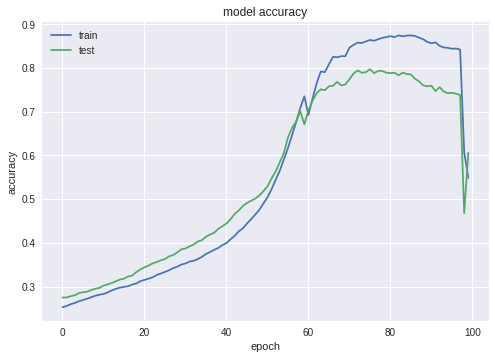

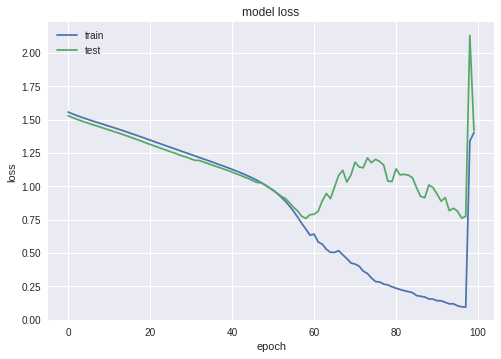

In [16]:
print(y.history.keys())
# summarize history for accuracy
plt.plot(y.history['acc'])
plt.plot(y.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(y.history['loss'])
plt.plot(y.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# convert images to LAB space and normalize

lab_train = np.zeros((ntrain, 224, 224, 3))
ii = 0
for im in train_images:
    lab_train[ii,::] = rgb2lab(im)
    ii = ii + 1
    # normalize ?

In [0]:
k = 1000
plt.figure(figsize=(40,20))
plt.subplot(2,4,1)
plt.imshow(train_images[k,::])
plt.axis('off')
for ii in range(0,3):
    plt.subplot(2,4,ii+2)
    plt.imshow(lab_train[k,:,:,ii])
    plt.gray()
    plt.axis('off')
im = train_images[k,::]
hsvim = rgb2hsv(im)
plt.subplot(2,4,6)
plt.imshow(hsvim[:,:,0])
plt.axis('off')
plt.subplot(2,4,7)
plt.imshow(hsvim[:,:,1])
plt.axis('off')
plt.subplot(2,4,8)
plt.imshow(hsvim[:,:,2])
plt.axis('off')
plt.show()